In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

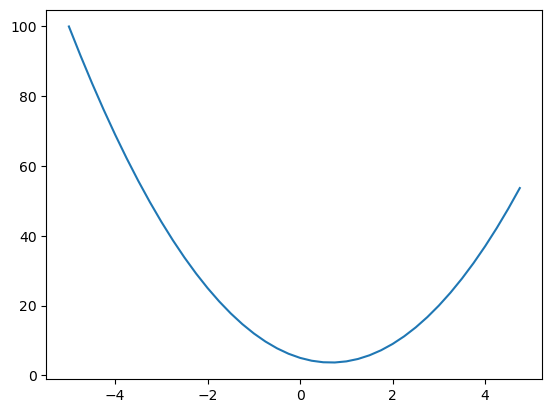

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __hash__(self):
        return id(self)
    
    def __add__(self,other):
        other  = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        
        return out
    
    
    def __mul__(self,other):
        other  = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data, (self,other),'*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self, ), 'exp')
        
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad = out.grad*other*(self.data**(other-1))
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self*other**-1
    
    def __neg__(self):
        return self.data*-1
    
    def __sub__(self,other):
        return self + (-other)
    

a = Value(2, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L
L._prev

{Value(data = -2.0), Value(data = 4.0)}

In [9]:
a = Value(4.0)
b = Value(2.0)
a*4

Value(data = 16.0)

In [10]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'}) #LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is result of an operation create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
            
    return dot

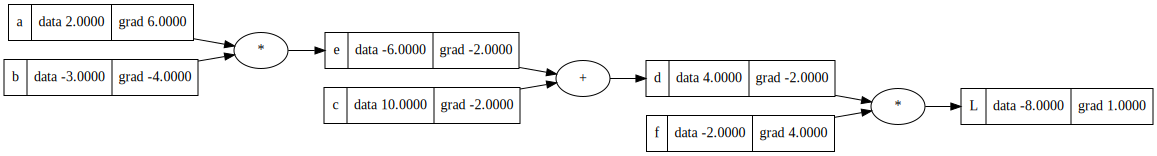

In [11]:
L.backward()
draw_dot(L)
# list(L._prev)[0].grad

In [12]:
import torch
import random

x1 = torch.Tensor([2.0]).double();                 x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                 x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                 w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();   b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [13]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [14]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [24]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        # w*x + b
        sum = Value(0.0)
        for wi, xi in zip(self.w,x):
            sum = (sum + xi*wi)
        act = sum + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        

class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [157]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
output = n(x)
output

Value(data = 0.8021818477413585)

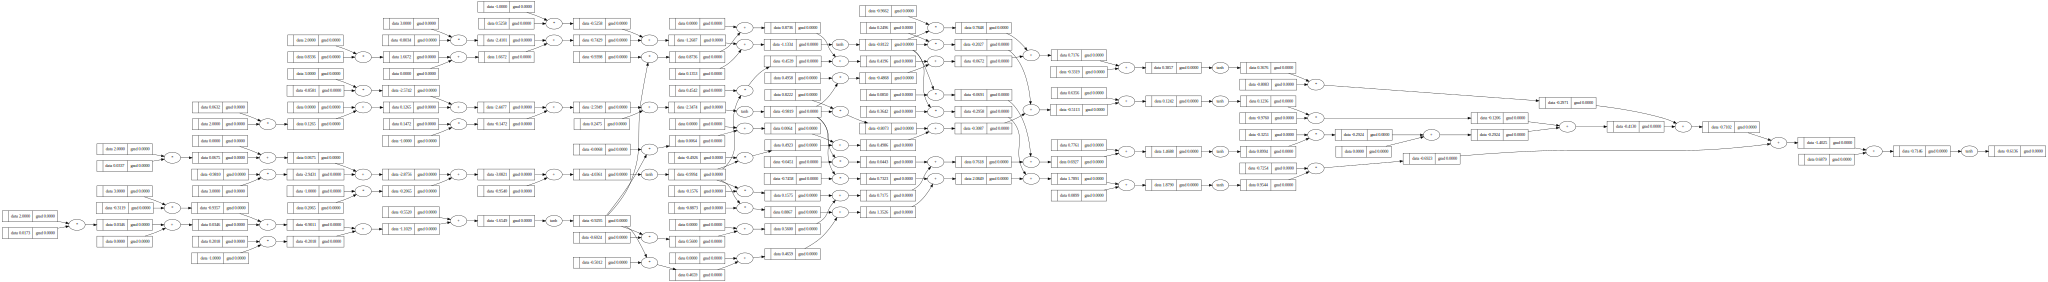

In [16]:
draw_dot(output)

In [17]:
output.backward()

In [159]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] # desired targets

In [165]:
for k in range(1000):
#     forward pass
    ypred = [n(x) for x in xs]
    loss = Value(0.0)
    for ygt, yout in zip(ys,ypred):
        loss = loss + (yout - ygt)**2
    
#     backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
#     update
    for p in n.parameters():
        p.data += -0.1*p.grad
    
    print(k,loss.data)

0 2.9259309891866686e-06
1 2.92580483288828e-06
2 2.925678688575818e-06
3 2.9255525562461e-06
4 2.9254264358996805e-06
5 2.9253003275332663e-06
6 2.925174231145172e-06
7 2.925048146733528e-06
8 2.9249220742983178e-06
9 2.9247960138349824e-06
10 2.9246699653436988e-06
11 2.9245439288220487e-06
12 2.9244179042689843e-06
13 2.92429189168168e-06
14 2.924165891059175e-06
15 2.924039902398918e-06
16 2.9239139256995472e-06
17 2.9237879609589593e-06
18 2.923662008176243e-06
19 2.9235360673495626e-06
20 2.9234101384764907e-06
21 2.923284221554902e-06
22 2.923158316584182e-06
23 2.9230324235622103e-06
24 2.9229065424865372e-06
25 2.922780673356133e-06
26 2.9226548161689212e-06
27 2.9225289709235105e-06
28 2.922403137617819e-06
29 2.922277316250113e-06
30 2.922151506818251e-06
31 2.9220257093208846e-06
32 2.9218999237567064e-06
33 2.921774150123127e-06
34 2.9216483884185417e-06
35 2.9215226386418706e-06
36 2.9213969007906776e-06
37 2.9212711748631585e-06
38 2.921145460858457e-06
39 2.921019758773

464 2.8686532976751044e-06
465 2.8685325182833674e-06
466 2.8684117500925066e-06
467 2.8682909931008833e-06
468 2.8681702473071876e-06
469 2.8680495127097293e-06
470 2.8679287893072335e-06
471 2.8678080770969254e-06
472 2.8676873760781583e-06
473 2.867566686248984e-06
474 2.8674460076084106e-06
475 2.8673253401536866e-06
476 2.8672046838835146e-06
477 2.8670840387976945e-06
478 2.8669634048923323e-06
479 2.866842782167556e-06
480 2.866722170621431e-06
481 2.8666015702521666e-06
482 2.866480981057448e-06
483 2.86636040303633e-06
484 2.8662398361877993e-06
485 2.8661192805095505e-06
486 2.8659987359994615e-06
487 2.865878202657063e-06
488 2.865757680479442e-06
489 2.8656371694664934e-06
490 2.8655166696154572e-06
491 2.8653961809253757e-06
492 2.8652757033942286e-06
493 2.865155237020992e-06
494 2.8650347818037474e-06
495 2.8649143377396433e-06
496 2.864793904829265e-06
497 2.864673483069408e-06
498 2.864553072459229e-06
499 2.864432672997376e-06
500 2.864312284681412e-06
501 2.864191907

879 2.8194733514400737e-06
880 2.81935708538597e-06
881 2.819240829889169e-06
882 2.8191245849469143e-06
883 2.819008350559416e-06
884 2.8188921267255128e-06
885 2.8187759134412815e-06
886 2.818659710707698e-06
887 2.818543518522068e-06
888 2.818427336883094e-06
889 2.8183111657887977e-06
890 2.818195005238323e-06
891 2.8180788552308243e-06
892 2.8179627157638318e-06
893 2.817846586835406e-06
894 2.817730468445507e-06
895 2.8176143605915855e-06
896 2.8174982632729054e-06
897 2.8173821764866777e-06
898 2.81726610023283e-06
899 2.8171500345089225e-06
900 2.8170339793140735e-06
901 2.8169179346467e-06
902 2.816801900505193e-06
903 2.8166858768882827e-06
904 2.816569863793595e-06
905 2.816453861221039e-06
906 2.8163378691685605e-06
907 2.8162218876338666e-06
908 2.816105916616786e-06
909 2.8159899561149447e-06
910 2.815874006126789e-06
911 2.815758066651682e-06
912 2.815642137686681e-06
913 2.815526219232261e-06
914 2.815410311285803e-06
915 2.8152944138459868e-06
916 2.815178526910812e-06

In [166]:
ypred

[Value(data = 0.9999727452544962),
 Value(data = -0.9998959072682213),
 Value(data = -0.9983286944606746),
 Value(data = 0.9999725034032181)]